# 라이브러리

In [3]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant
import pprint

import gensim
import gensim.models


# 데이터 준비와 확인


In [4]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성 

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}


In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['']]+[word_to_index[word] if word in word_to_index else word_to_index[''] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '' for index in encoded_sentence[1:])  #[1:]를 통해 를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 모델 구성을 위한 데이터 분석 및 가공

In [8]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함 '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함 


In [9]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가 (pre)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[""],
                                                       padding='pre',
                                                       maxlen=maxlen)

# 모델 구성 및 validation set 구성 

### RNN

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)


(136182, 41)
(136182,)


# 모델 훈련 개시

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.4683 - accuracy: 0.7913 - val_loss: 0.3537 - val_accuracy: 0.8471
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3362 - accuracy: 0.8583 - val_loss: 0.3389 - val_accuracy: 0.8536
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3147 - accuracy: 0.8684 - val_loss: 0.3392 - val_accuracy: 0.8515
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3012 - accuracy: 0.8740 - val_loss: 0.3343 - val_accuracy: 0.8544
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2901 - accuracy: 0.8798 - val_loss: 0.3382 - val_accuracy: 0.8566
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2796 - accuracy: 0.8852 - val_loss: 0.3401 - val_accuracy: 0.8542
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2704 - accuracy: 0.8887 - val_loss: 0.3461 - val_accuracy: 0.8529
Epoch 

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


1537/1537 - 3s - loss: 0.4718 - accuracy: 0.8409
[0.47180622816085815, 0.8408568501472473]


# Loss, Accuracy 그래프 시각화 

In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


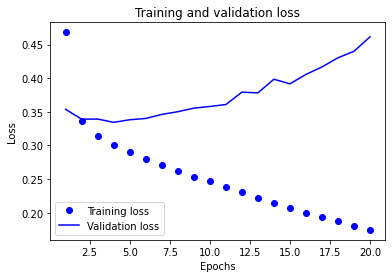

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


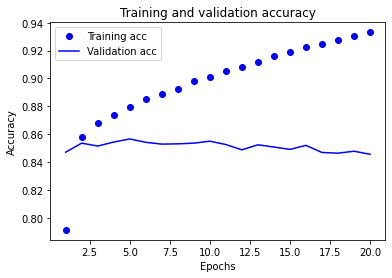

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['달']
vector

array([ 0.02664859, -0.04974878,  0.0309967 ,  0.02935936,  0.03585061,
        0.04865687, -0.0136223 ,  0.00282244,  0.0460978 , -0.08503485,
        0.02148219, -0.01486456, -0.03386727, -0.0032571 , -0.0134083 ,
        0.07319696], dtype=float32)

In [21]:
word_vectors.similar_by_word("달")

[('식민지', 0.7765988707542419),
 ('에디', 0.6864718198776245),
 ('전개', 0.6655558943748474),
 ('성경', 0.6602135300636292),
 ('레디', 0.6434792876243591),
 ('젼', 0.6422222256660461),
 ('모녀', 0.6382995247840881),
 ('스티븐시걸', 0.628669261932373),
 ('공포감', 0.6247571706771851),
 ('어야', 0.6240862607955933)]

### CNN

In [22]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# 모델 훈련 개시

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.4903 - accuracy: 0.7475 - val_loss: 0.3501 - val_accuracy: 0.8466
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3303 - accuracy: 0.8593 - val_loss: 0.3397 - val_accuracy: 0.8501
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.8739 - val_loss: 0.3381 - val_accuracy: 0.8535
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2796 - accuracy: 0.8849 - val_loss: 0.3389 - val_accuracy: 0.8551
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2546 - accuracy: 0.8986 - val_loss: 0.3411 - val_accuracy: 0.8551
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2259 - accuracy: 0.9121 - val_loss: 0.3615 - val_accuracy: 0.8533
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1954 - accuracy: 0.9273 - val_loss: 0.3828 - val_accuracy: 0.8517
Epoch 

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.9369 - accuracy: 0.8187
[0.9369192719459534, 0.8186626434326172]


# Loss, Accuracy 그래프 시각화 

In [26]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


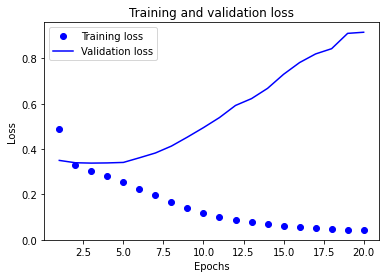

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

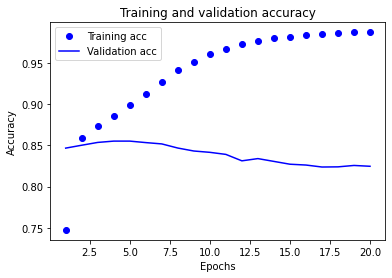

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# 학습된 Embedding 레이어 분석

In [29]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [30]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['달']
vector

array([-0.01578432,  0.09185387, -0.09766891,  0.06446405, -0.0077763 ,
       -0.05826878,  0.23756908,  0.00046426, -0.08100425, -0.01067946,
        0.07460994, -0.00993314, -0.0217018 ,  0.16435115,  0.09809059,
        0.03716528], dtype=float32)

In [33]:
word_vectors.similar_by_word("달")


[('이별', 0.7556570172309875),
 ('인터', 0.7339990735054016),
 ('레이', 0.7302796840667725),
 ('느라', 0.7181926965713501),
 ('나름', 0.7086923718452454),
 ('이중', 0.7022141814231873),
 ('이연희', 0.7016173601150513),
 ('당함', 0.6878142952919006),
 ('줘도', 0.684593141078949),
 ('벌레', 0.6824586391448975)]

### GMP

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [35]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)


(136182, 41)
(136182,)


# 모델 훈련 개시

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5626 - accuracy: 0.7193 - val_loss: 0.4076 - val_accuracy: 0.8256
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3665 - accuracy: 0.8424 - val_loss: 0.3519 - val_accuracy: 0.8446
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3206 - accuracy: 0.8643 - val_loss: 0.3453 - val_accuracy: 0.8482
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2949 - accuracy: 0.8770 - val_loss: 0.3481 - val_accuracy: 0.8479
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2764 - accuracy: 0.8863 - val_loss: 0.3533 - val_accuracy: 0.8462
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2613 - accuracy: 0.8936 - val_loss: 0.3607 - val_accuracy: 0.8436
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2489 - accuracy: 0.9002 - val_loss: 0.3690 - val_accuracy: 0.8430
Epoch 

In [37]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5120 - accuracy: 0.8258
[0.5119626522064209, 0.8257827162742615]


# Loss, Accuracy 그래프 시각화

In [38]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


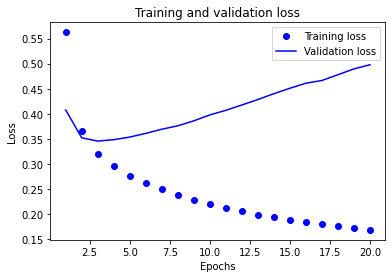

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


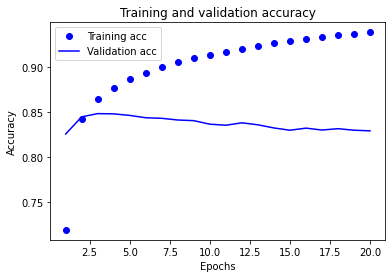

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 Embedding 레이어 분석

In [41]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [42]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)



In [44]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['달']
vector

array([-0.05046583,  0.06922263, -0.06735323, -0.1387774 , -0.00909616,
       -0.02612368, -0.00128218, -0.01050064, -0.01898175, -0.05778922,
       -0.22604297, -0.02979614,  0.10763256, -0.22537148,  0.00097961,
       -0.08324368], dtype=float32)

In [45]:
word_vectors.similar_by_word("달")


[('레디', 0.8071303963661194),
 ('노인', 0.8004963994026184),
 ('슬퍼서', 0.8002038598060608),
 ('이득', 0.7933408617973328),
 ('능', 0.7923616766929626),
 ('여배우', 0.7720946669578552),
 ('브로디', 0.7602825164794922),
 ('어지간', 0.7569475769996643),
 ('소신', 0.7550654411315918),
 ('그래도', 0.7491889595985413)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선 

In [46]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)


In [51]:
word2vec.wv.similar_by_word("달")

[('열흘', 0.5392864942550659),
 ('매달', 0.539036750793457),
 ('며칠', 0.5376834869384766),
 ('사흘', 0.529775083065033),
 ('닷새', 0.5225986242294312),
 ('하루', 0.5175581574440002),
 ('이틀', 0.5118764638900757),
 ('날', 0.5048810243606567),
 ('개월', 0.5025528073310852),
 ('쏘', 0.49431291222572327)]

In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [55]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.3926 - accuracy: 0.8199 - val_loss: 0.3288 - val_accuracy: 0.8535
Epoch 2/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.2946 - accuracy: 0.8745 - val_loss: 0.3050 - val_accuracy: 0.8673
Epoch 3/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.2560 - accuracy: 0.8932 - val_loss: 0.3194 - val_accuracy: 0.8631
Epoch 4/20
2128/2128 [==============================] - 12s 5ms/step - loss: 0.2228 - accuracy: 0.9090 - val_loss: 0.3155 - val_accuracy: 0.8693
Epoch 5/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1908 - accuracy: 0.9236 - val_loss: 0.3311 - val_accuracy: 0.8695
Epoch 6/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1585 - accuracy: 0.9374 - val_loss: 0.3683 - val_accuracy: 0.8650
Epoch 7/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1305 - accuracy: 0.9505 - val_loss: 0.4037 - val_ac

In [57]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


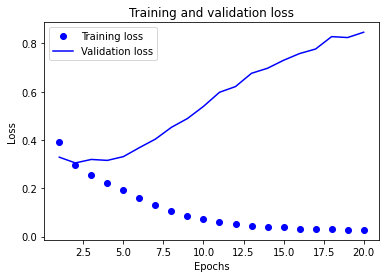

In [58]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

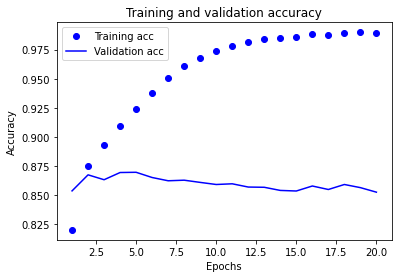

In [59]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [60]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


1537/1537 - 3s - loss: 0.8460 - accuracy: 0.8522
[0.8459510207176208, 0.852228581905365]


Word2Vec = 0.8522

3가지 모델 결과 

RNN: 0.8435
CNN: 0.8191
GMP: 0.8274

이 경우 RNN이 가장 좋은 모델임. 
